# Step 1 - Climate Analysis and Exploration

In [1]:
# -- dependencies and setup --
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as st

In [2]:
# --- Python SQL toolkit and Object Relational Mapper ---
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

### Reflect Tables into SQLAlchemy ORM

In [3]:
# --- create engine using the `hawaii.sqlite` database file ---
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# --- declare a Base using `automap_base()` ---
Base = automap_base()

# --- use the Base class to reflect the database tables ---
Base.prepare(engine, reflect=True)

In [5]:
# --- view all of the classes that automap found ---
Base.classes.keys()

['measurement', 'station']

In [6]:
# --- save references to each table ---
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# --- create a session (link) from Python to the DB ---
session = Session(engine)
inspector = inspect(engine)

# --- check columns from the two tables ---
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"], column["type"])
print("-"*12)
s_columns = inspector.get_columns('station')
for c in s_columns:
     print(c["name"], c["type"])   

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis
1. Design a query to retrieve the last 12 months of precipitation data.
2. Select only the date and prcp values.
3. Load the query results into a Pandas DataFrame and set the index to the date column.
4. Sort the DataFrame values by date.
5. Plot the results using the DataFrame plot method.
6. Use Pandas to print the summary statistics for the precipitation data.

Checking for null values...
There are 209 null values - dropping!
Plotting precipitation data...


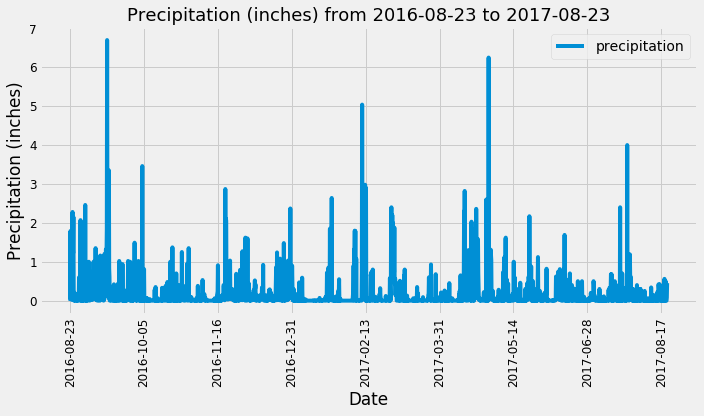

In [8]:
# ************************
# PRECIPITATION ANALYSIS
# ************************

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# --- query the db and get the last data point (first in the descending order list) and find the date ---
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

# --- convert string date to date format for use with datetime library ---
last_dt = dt.date.fromisoformat(last_date)

# --- calculate the date 1 year ago from the last data point in the database (using dt.timedelta) ---
date_oneyearago = last_dt - dt.timedelta(days=365)

# --- perform a query to retrieve the data and precipitation scores ---
prcp_data = session.query(measurement.date, measurement.prcp).\
            filter((measurement.date >= date_oneyearago)\
                    & (measurement.date <= last_dt)).all()

# --- save the query results as a Pandas DataFrame, sort by date and set the index to the date column ---
prcp_df = pd.DataFrame(prcp_data).sort_values("date").set_index("date")

# --- rename prcp column ---
prcp_df.rename(columns={"prcp":"precipitation"}, inplace=True)

# --- check and drop null values ---
print("Checking for null values...")
print(f"There are {prcp_df['precipitation'].isnull().sum()} null values - dropping!")

prcp_df.dropna(axis=0, how="any", inplace=True)

print("Plotting precipitation data...")

# --- use Pandas Plotting with Matplotlib to plot the data ---
prcp_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.title(f"Precipitation (inches) from {date_oneyearago} to {last_dt}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()


In [9]:
# --- use Pandas to calculate the summary statistics for the precipitation data ---
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis
1. Design a query to calculate the total number of stations.
2. Design a query to find the most active stations.
    - List the stations and observation counts in descending order.
    - Which station has the highest number of observations?
3. Design a query to retrieve the last 12 months of temperature observation data (TOBS).
    - Filter by the station with the highest number of observations.
    - Plot the results as a histogram with bins=12.

In [10]:
# ************************
# STATION ANALYSIS
# ************************

# Design a query to show how many stations are available in this dataset?
num_station = session.query(station).count()

print("Counting from station table:")
print(f"There are {num_station} stations in the dataset.\n")

# --- using sqlalchemy distinct ---
from sqlalchemy import distinct
distinct_stations = session.query(distinct(measurement.station)).count()

print("Counting from measurement table (using distinct):")
print(f"There are {distinct_stations} stations in the dataset.")


Counting from station table:
There are 9 stations in the dataset.

Counting from measurement table (using distinct):
There are 9 stations in the dataset.


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()

# --- display the active stations ---
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# --- identify most active station ---
most_active_station = active_stations[0][0]
print (f"The most active station is {most_active_station}.")
print("---------------------------------------------")

# --- calculate lowest temp recorded at the most active station USC00519281 ---
lowest_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
              
print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit.")

# --- calculate highest temp recorded at the most active station USC00519281 ---
highest_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Highest temperature: {highest_temp} degrees Fahrenheit.")

# --- calculate average temp recorded at the most active station USC00519281 ---
avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Average temperature : {round(avg_temp, 2)} degrees Fahrenheit.")

The most active station is USC00519281.
---------------------------------------------
Lowest temperature: 54.0 degrees Fahrenheit.
Highest temperature: 85.0 degrees Fahrenheit.
Average temperature : 71.66 degrees Fahrenheit.


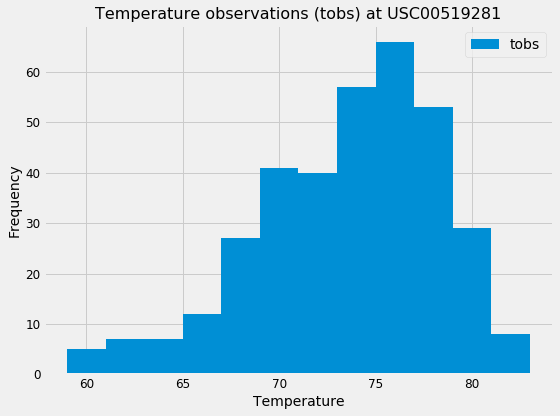

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# --- create a dataframe from temp observations in last 12 months at most active station ---
most_active_tobs = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= date_oneyearago)\
                                        & (measurement.date <= last_dt)).all())

most_active_tobs.plot(kind="hist", figsize=(8,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {most_active_station}", fontsize=16)

plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


# Step 2 - Climate App
This web app can be run using 'app.py'
**********************************************************************************************************************

## Bonus Challenge 1: Temperature Analysis I
Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

1. Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

2. Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [14]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

# --- get all temps from dataset using SQLAlchemy and save in dataframe ---
temps_df = pd.DataFrame(session.query(measurement.date, measurement.station, measurement.tobs).all())

# --- convert string date to datetime object to be able to search by month ---
temps_df['date'] = pd.to_datetime(temps_df['date'])

# --- new groupby object with average june temperature observations by station ---
june_temps = temps_df[temps_df['date'].dt.month == 6].groupby(['station']).mean()


# --- new groupby object with average december temperature observations by station ---
dec_temps = temps_df[temps_df['date'].dt.month == 12].groupby(['station']).mean()


In [15]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?

# --- calculate p-value using paired t-test ---
print(f"P-value using paired t-test: {st.ttest_rel(june_temps.tobs, dec_temps.tobs)[1]}")


P-value using paired t-test: 0.00011759380231523222


### Temperature Analysis I
Null hypothesis: The mean difference between the temperatures in June and December is zero. <br>

A paired t-test was used as we are comparing the means of the same group i.e. in this case, the mean temperature observations are of the same stations, just for different timepoints.
The p-value of 0.0001 is less than 0.05 so we reject the null hypothesis and conclude that the data is statistically significant.

## Bonus Challenge 2: Temperature Analysis II
1. The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.
2. Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").
3. Plot the min, avg, and max temperature from your previous query as a bar chart.
    - Use the average temperature as the bar height.
    - Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# --- define start and end dates of vacation ---
start_date = '2018-06-01'
end_date = '2018-06-15'

# --- convert string date to date format for use with datetime library ---
start_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

# --- calculate the dates 1 year ago from the start_date and end_date (using dt.timedelta) ---
startdate_oneyearago = (start_dt - dt.timedelta(days=365)).date()
enddate_oneyearago = (end_dt - dt.timedelta(days=365)).date()

# --- call the calc_temps function with the previous year dates calculated above ---
temps = calc_temps(startdate_oneyearago, enddate_oneyearago)
tmin = temps[0][0]
tavg = round(temps[0][1], 2)
tmax = temps[0][2]

# --- display temperature info ---
print(f"Vacation start date: {start_date} | Vacation end date: {end_date}")
print("----------------------------------------------------------------")
print(f"Temperatures from {startdate_oneyearago} to {enddate_oneyearago}:")
print(f"Minimum temp: {tmin} | Average temp: {tavg} | Max temp: {tmax}")


Vacation start date: 2018-06-01 | Vacation end date: 2018-06-15
----------------------------------------------------------------
Temperatures from 2017-06-01 to 2017-06-15:
Minimum temp: 72.0 | Average temp: 77.42 | Max temp: 83.0


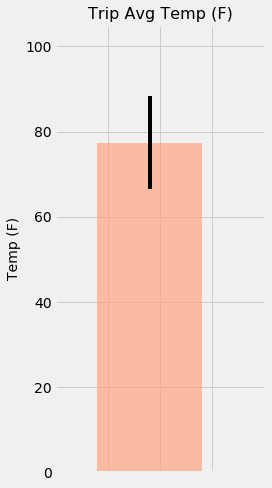

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# --- calculate yerror value ((tmax-tmin) ---
yerror = tmax-tmin

# --- plot data as bar chart ---
plt.figure(figsize = (4,7))
plt.bar(1.5, height=tavg, yerr=yerror, width = 2, color='lightsalmon', alpha = 0.65,  align='center')
xaxis_values = np.arange(-0.3,3.8, step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values, "")

plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

## Bonus Challenge 3: Daily Rainfall Average
1. Calculate the rainfall per weather station using the previous year's matching dates.
2. Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
3. You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.
4. Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
5. Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
6. Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# --- get all precipitation data from dataset for one year ago dates using SQLAlchemy and save in dataframe ---
prcp_station_df = pd.DataFrame(session.query(measurement.date, measurement.station, measurement.prcp).\
                               filter((measurement.date >= startdate_oneyearago) & \
                               (measurement.date <= enddate_oneyearago)).all())

# --- check and drop null values from prcp_station_df---
print("Checking for null values...")
print(f"There are {prcp_station_df['prcp'].isnull().sum()} null values in the precipitation data - dropping!")

prcp_station_df.dropna(axis=0, how="any", inplace=True)

# --- group by station and get total precipitation amount for each station ---
total_prcp = pd.DataFrame(prcp_station_df.groupby('station').sum())

# --- get station data from station table and save in dataframe ---
station_df = pd.DataFrame(session.query(station.station, station.name, station.latitude, station.longitude,\
                                        station.elevation).all())


# --- merge the two dataframes together, sort by total precipitation amount ---
rainfall_per_station_df = pd.merge(total_prcp, station_df, on="station").rename(columns={"prcp":"total precipitation"})
rainfall_per_station_df.sort_values('total precipitation', ascending=False, inplace=True)
rainfall_per_station_df.reset_index(inplace=True, drop=True)

# --- display the dataframe ---
rainfall_per_station_df


Checking for null values...
There are 11 null values in the precipitation data - dropping!


,station,total precipitation,name,latitude,longitude,elevation
0,USC00516128,5.51,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.98,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,2.02,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,1.96,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.76,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.16,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date.fromisoformat('2018-06-01')
end_date = dt.date.fromisoformat('2018-06-15')

# Use the start and end date to create a range of dates

# --- create an empty list to store range of dates ---
trip_dates = []

# --- new variable to act as start date (so that actual start date is unchanged) ---
current_date = start_date

# --- while loop to append dates to list in the format %m-%d ---
while current_date <= end_date:
    month = current_date.strftime('%m')
    day = current_date.strftime('%d')
    trip_dates.append(f"{month}-{day}")
    current_date += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date

# --- create an empty list to store normals ---
normals = []

# --- for loop to calculate normals for each date in trip_dates list ---
for i in range(len(trip_dates)):
    day_normal = daily_normals(trip_dates[i])
    normals.append(day_normal[0])
    
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

dailynormals_df = pd.DataFrame(normals, columns =['T-Min', 'T-Avg', 'T-Max']) 
dailynormals_df["Date"] = trip_dates
dailynormals_df.set_index("Date")

,T-Min,T-Avg,T-Max
Date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


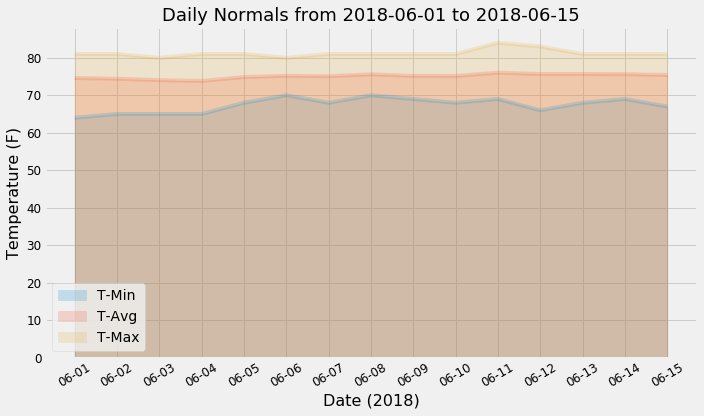

In [22]:
# Plot the daily normals as an area plot with `stacked=False`

dailynormals_df.plot.area(figsize=(10,6), stacked=False, alpha = 0.2, rot=30, fontsize=12)

plt.xticks(np.arange(len(trip_dates)), labels=trip_dates)

plt.title(f"Daily Normals from {start_date} to {end_date}", fontsize=18)
plt.xlabel("Date (2018)", fontsize=16)
plt.ylabel("Temperature (F)", fontsize=16)

plt.tight_layout()
plt.savefig("Images/dailynormals.png")
plt.show()